In [1]:
%load_ext autoreload
%autoreload 2

import torch
torch.manual_seed(42)
import torch.nn as nn

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from laplace import Laplace

from full_la import FullLA

from tqdm import tqdm

from helper_function import banana_dataloaders

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/lir3/miniconda3/envs/bdl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train: 264, Val: 3974, Test: 1059


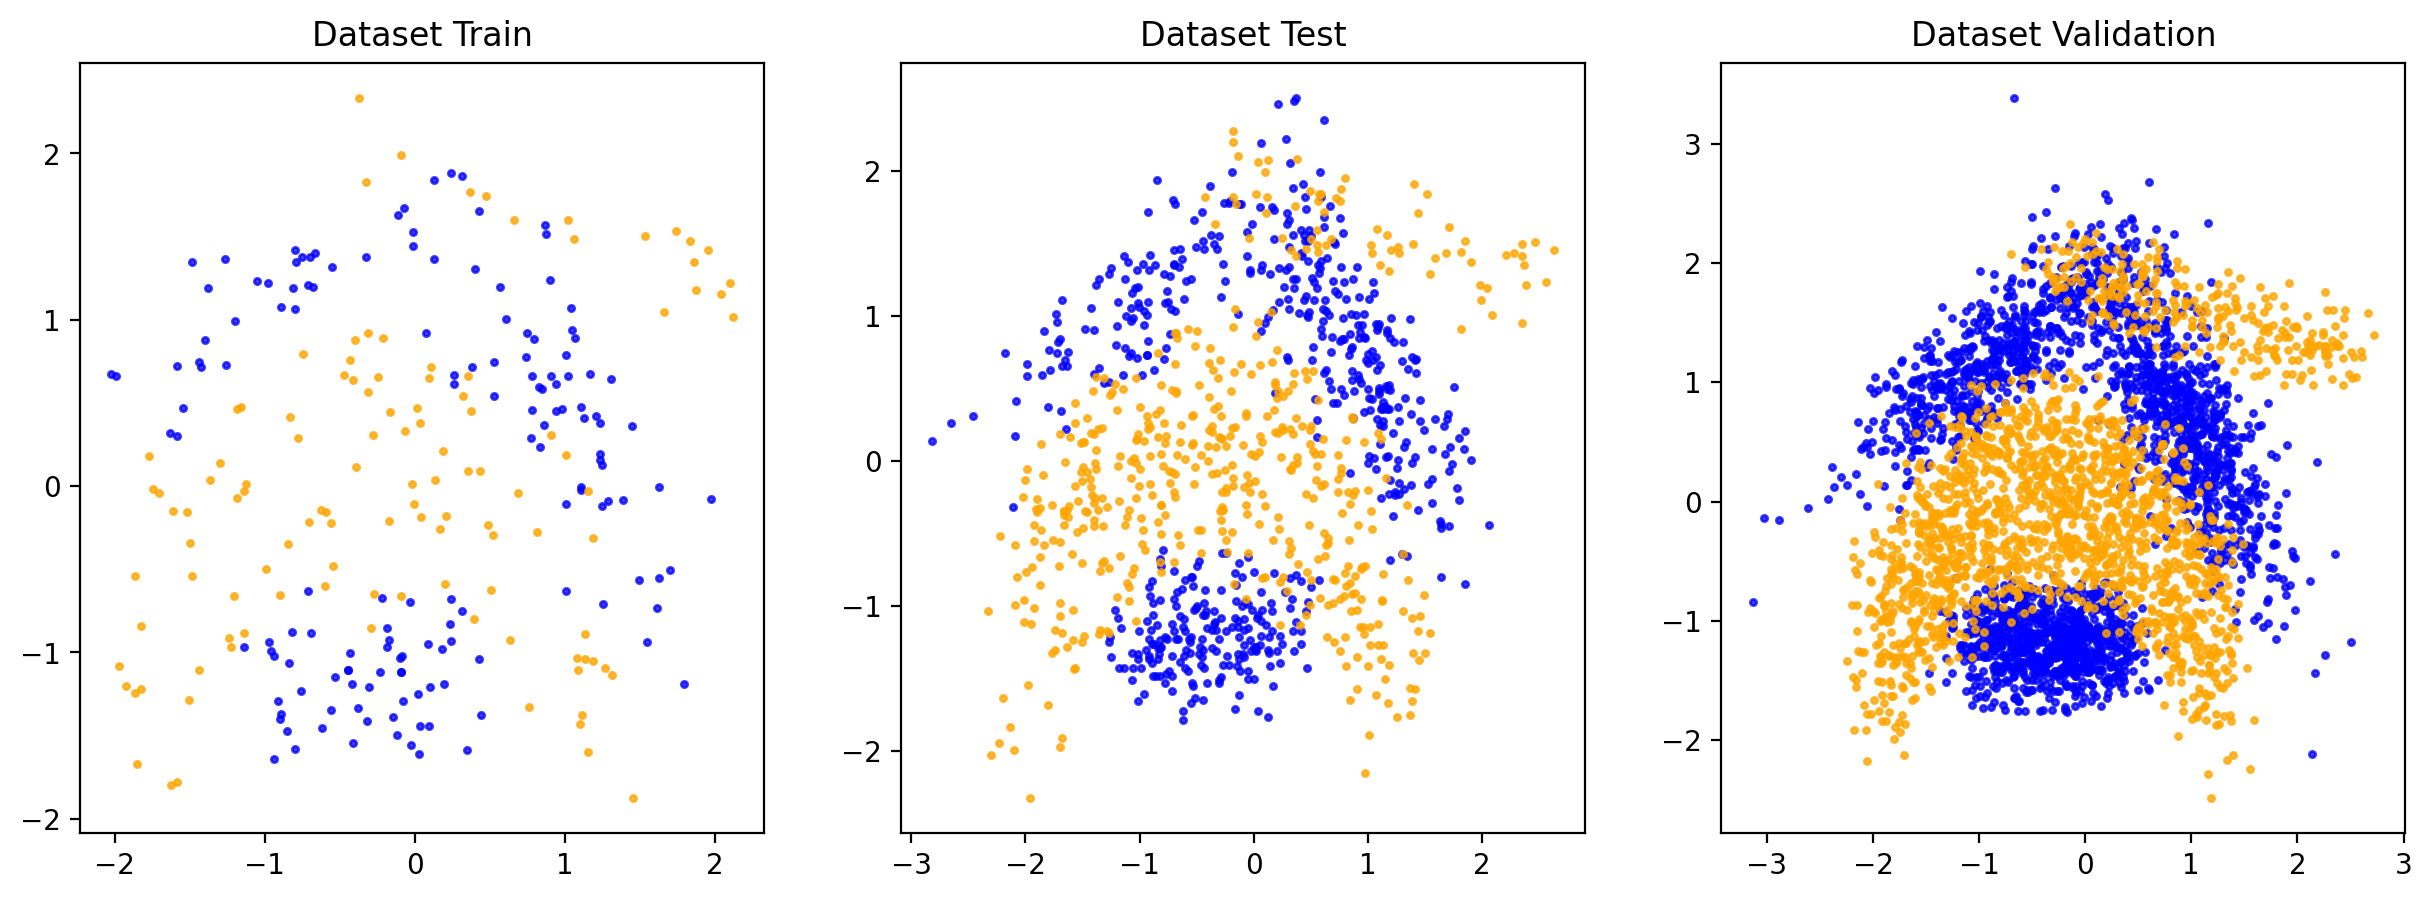

In [2]:
train_loader, test_loader, val_loader = banana_dataloaders(train_ratio=0.05, val_ratio=0.75, test_ratio=0.2, batch_size = 64)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

for (axs, loader, name) in zip([ax1, ax2, ax3], [train_loader, test_loader, val_loader], ["Train", "Test", "Validation"]):
    x = loader.dataset.X.numpy()
    try:
        y = loader.dataset.Y.argmax(dim=1).numpy()
    except:
        y = loader.dataset.Y.numpy()
    axs.scatter(x[y == 0, 0], x[y == 0, 1], c='blue', s=5, alpha=0.75)
    axs.scatter(x[y == 1, 0], x[y == 1, 1], c='orange', s=5, alpha=0.75)
    axs.set_title(f"Dataset {name}")

In [3]:
class TinyMLP(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=50, out_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim, bias = False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim, bias = False)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, out_dim, bias = False)

    def forward(self, x):
        h1 = self.fc1(x)
        a1 = self.relu1(h1)
        h2 = self.fc2(a1)
        a2 = self.relu2(h2)
        out = self.fc3(a2)
        
        return out

100%|██████████| 500/500 [00:01<00:00, 330.60it/s]


Text(0, 0.5, 'Loss')

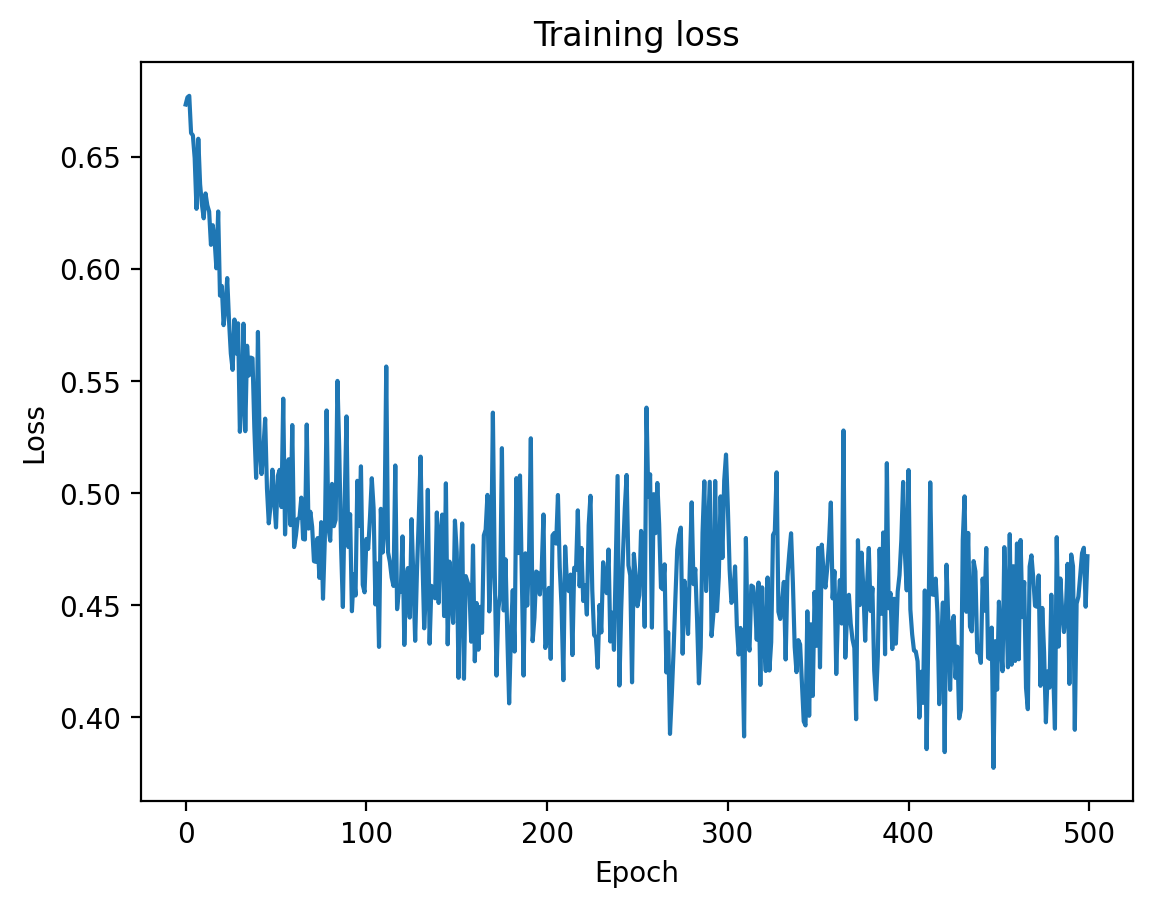

In [4]:
model = TinyMLP()
model.to(device)

### train model
n_epochs = 500
lr = 0.001
weight_decay = 1e-5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
print_every = 20

loss_value = []

for i in tqdm(range(n_epochs)):
    
    ell = 0
    for X, y in train_loader:
        optimizer.zero_grad()
        pred = model(X.to(device))
        loss = criterion(pred, y.to(device))
        loss.backward()
        optimizer.step()
        ell += loss.item()
        
    loss_value.append(ell/len(train_loader))
    
# plot the training loss
plt.plot(loss_value)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [5]:
###################################################
############ hessian estimation test  #############
###################################################

GGN_la = FullLA(model, 1.0, 'GGN')
EF_la = FullLA(model, 1.0, 'EF')

GGN_la.estimate_hessian(train_loader)
EF_la.estimate_hessian(train_loader)

params = [p for p in model.parameters() if p.requires_grad]
num_params = sum(p.numel() for p in params)
num_params_layer = [
    sum(p.numel() for p in child.parameters()) for child in model.children()
]

loss_function = nn.CrossEntropyLoss(reduction='sum')
identity = torch.eye(num_params)

def test_GGN_Hessian(model, data_loader, GGN_H):
    from curvlinops import GGNLinearOperator

    data = [(data_loader.dataset.X, data_loader.dataset.Y)]
    GGN_linop = GGNLinearOperator(model, loss_function, params, data)
    
    curvlinops_GGN_H = GGN_linop @ identity
    
    torch.testing.assert_close(GGN_H.detach().numpy(), curvlinops_GGN_H)

def test_EF_Hessian(model, data_loader, EF_H):
    from curvlinops import EFLinearOperator

    data = [(data_loader.dataset.X, data_loader.dataset.Y)]
    EF_linop = EFLinearOperator(model, loss_function, params, data)
    
    curvlinops_EF_H = EF_linop @ identity
    
    torch.testing.assert_close(EF_H.detach().numpy(), curvlinops_EF_H)
        
test_GGN_Hessian(model, train_loader, GGN_la.H)
test_EF_Hessian(model, train_loader, EF_la.H)

    

In [6]:
####################################################
############ marginal likelihood test  #############
####################################################

def test_marginal_likelihood(model, train_loader, my_la):
    
    from laplace.curvature.curvlinops import CurvlinopsGGN
    
    ggn_la = Laplace(model, 'classification', subset_of_weights='all', hessian_structure='full', backend = CurvlinopsGGN)
    ggn_la.fit(train_loader)
    
    for scale in [1, 10, 100]:
    
        ggn_la.prior_precision.data = torch.rand(1) * scale # [0, scale]
        
        log_marg_lik = my_la.compute_log_marginal_likelihood(train_loader, ggn_la.prior_precision)
        
        la_log_marg_lik = ggn_la.log_marginal_likelihood() 
        
        torch.testing.assert_close(log_marg_lik.item(), la_log_marg_lik.item(), atol = 1e-5, rtol = 1e-5)

test_marginal_likelihood(model, train_loader, GGN_la)


In [7]:
GGN_la.optimize_prior_precision(1e-2, 10, train_loader)

Epoch 0: log marg lik -220.749
Epoch 1: log marg lik -220.307
Epoch 2: log marg lik -219.867
Epoch 3: log marg lik -219.430
Epoch 4: log marg lik -218.995
Epoch 5: log marg lik -218.562
Epoch 6: log marg lik -218.131
Epoch 7: log marg lik -217.703
Epoch 8: log marg lik -217.277
Epoch 9: log marg lik -216.854
